Import
************

In [1]:
from datasets import load_dataset, load_from_disk, Dataset, Features, Array3D
from transformers import AutoProcessor, ViTFeatureExtractor, ViTForImageClassification, Trainer, TrainingArguments, default_data_collator
import pyarrow as pa
import evaluate
import numpy as np
from typing import Tuple
import torch
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define Path
************

In [2]:
# The directory where our images are saved in folders by category
images_dir = "Aug_Rocks"

# The output directory of the processed datasets
train_save_path = "./processed-datasets/Augmented/train"
val_save_path = "./processed-datasets/Augmented/val"
test_save_path = "./processed-datasets/Augmented/test"


# Name of model as named in the HuggingFace Hub
model_name = "google/vit-base-patch16-224-in21k"


Load Dataset & Convert to RGB
************

In [3]:
dataset = load_dataset("imagefolder", data_dir=images_dir, split='train')

condition = lambda data: data['image'].mode == 'RGB'
dataset = dataset.filter(condition)

Resolving data files: 100%|██████████| 2432/2432 [00:00<00:00, 43753.07it/s]


Split Dataset to (Test/Train/Validate)
************

In [4]:
def split_dataset(
    dataset: Dataset,
    val_size: float=0.2,
    test_size: float=0.1
) -> Tuple[Dataset, Dataset, Dataset]:
    """
    Returns a tuple with three random train, validation and test subsets by splitting the passed dataset.
    Size of the validation and test sets defined as a fraction of 1 with the `val_size` and `test_size` arguments.
    """

    print("Splitting dataset into train, validation and test sets...")

    # Split dataset into train and (val + test) sets
    split_size = round(val_size + test_size, 3)
    dataset = dataset.train_test_split(shuffle=True, test_size=split_size)

    # Split (val + test) into val and test sets
    split_ratio = round(test_size / (test_size + val_size), 3)
    val_test_sets = dataset['test'].train_test_split(shuffle=True, test_size=split_ratio)

    train_dataset = dataset["train"]
    val_dataset = val_test_sets["train"]
    test_dataset = val_test_sets["test"]
    return train_dataset, val_dataset, test_dataset

# Sizes of dataset splits
val_size = 0.2
test_size = 0.1

# Split dataset into train and test sets
train_dataset, val_dataset, test_dataset = split_dataset(dataset, val_size, test_size)

Splitting dataset into train, validation and test sets...


Transform Image
************

In [5]:
pa.PyExtensionType.set_auto_load(True)

def process_examples(examples, image_processor):
    
    # Get batch of images
    images = examples['image']

    # Preprocess
    inputs = image_processor(images=images)
    # Add pixel_values
    examples['pixel_values'] = inputs['pixel_values']

    return examples


def apply_processing(
    model_name: str,
    train_dataset: Dataset,
    val_dataset: Dataset,
    test_dataset: Dataset
) -> Tuple[Dataset, Dataset, Dataset]:
    """
    Apply model's image AutoProcessor to transform train, validation and test subsets.
    Returns train, validation and test datasets with `pixel_values` in torch tensor type.
    """

    # Extend the features 
    features = Features({
        **train_dataset.features,
        'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    })

    # Instantiate image_processor
    image_processor = AutoProcessor.from_pretrained(model_name)
    
    # Preprocess images
    train_dataset = train_dataset.map(process_examples, batched=True, features=features, fn_kwargs={"image_processor": image_processor})
    val_dataset = val_dataset.map(process_examples, batched=True, features=features, fn_kwargs={"image_processor": image_processor})
    test_dataset = test_dataset.map(process_examples, batched=True, features=features, fn_kwargs={"image_processor": image_processor})

    # Set to torch format for training
    train_dataset.set_format('torch', columns=['pixel_values', 'label'])
    val_dataset.set_format('torch', columns=['pixel_values', 'label'])
    test_dataset.set_format('torch', columns=['pixel_values', 'label'])
    
    # Remove unused column
    train_dataset = train_dataset.remove_columns("image")
    val_dataset = val_dataset.remove_columns("image")
    test_dataset = test_dataset.remove_columns("image")
    
    return train_dataset, val_dataset, test_dataset


# Apply AutoProcessor
train_dataset, val_dataset, test_dataset = apply_processing(model_name, train_dataset, val_dataset, test_dataset)

Map:   0%|          | 0/1623 [00:00<?, ? examples/s]c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\datasets\features\features.py:648: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  pa.PyExtensionType.__init__(self, self.storage_dtype)
Map: 100%|██████████| 232/232 [00:08<00:00, 26.25 examples/s]


Save Transformed Dataset
************

In [6]:
# Save train, validation and test preprocessed datasets
train_dataset.save_to_disk(train_save_path, num_shards=1)

val_dataset.save_to_disk(val_save_path, num_shards=1)

test_dataset.save_to_disk(test_save_path, num_shards=1)

Saving the dataset (0/1 shards):   0%|          | 0/1623 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 232/232 [00:00<00:00, 1005.32 examples/s]


Load Transformed Dataset
************

In [7]:
train_dataset = load_from_disk(train_save_path)

val_dataset = load_from_disk(val_save_path)

Define Model & 
************

In [8]:
model = ViTForImageClassification.from_pretrained(model_name, num_labels=7)

# Download feature extractor from hub
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Acer\AppData\Local\Prog

Create Evaluation Metric
************

In [9]:
# Compute metrics function for binary classification
acc_metric = evaluate.load("accuracy", module_type="metric")

def compute_metrics(eval_pred):
    predicted_probs, labels = eval_pred
    # Accuracy
    predicted_labels = np.argmax(predicted_probs, axis=1)
    acc = acc_metric.compute(predictions=predicted_labels, references=labels)
    return acc

Target Class Encode-Decode
************

In [10]:
id2label = {key:train_dataset.features["label"].names[index] for index,key in enumerate(model.config.id2label.keys())}
label2id = {train_dataset.features["label"].names[index]:value for index,value in enumerate(model.config.label2id.values())}
model.config.id2label = id2label
model.config.label2id = label2id

Define Training Hyperparameter & Argument
************

In [11]:
model_dir = "./model"
output_data_dir = "./outputs"

# Total number of training epochs to perform
num_train_epochs = 15
# The batch size per GPU/TPU core/CPU for training
per_device_train_batch_size = 16
# The batch size per GPU/TPU core/CPU for evaluation
per_device_eval_batch_size = 16
# The initial learning rate for AdamW optimizer
learning_rate = 2e-5
# Number of steps used for a linear warmup from 0 to learning_rate
warmup_steps = 500
# The weight decay to apply to all layers except all bias and LayerNorm weights in AdamW optimizer
weight_decay = 0.01

main_metric_for_evaluation = "accuracy"

Apply Training Arguments
************

In [12]:
training_args = TrainingArguments(
    output_dir = model_dir,
    num_train_epochs = num_train_epochs,
    per_device_train_batch_size = per_device_train_batch_size,
    per_device_eval_batch_size = per_device_eval_batch_size,
    warmup_steps = warmup_steps,
    weight_decay = weight_decay,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    logging_strategy = "epoch",
    logging_dir = f"{output_data_dir}/logs",
    learning_rate = float(learning_rate),
    load_best_model_at_end = True,
    metric_for_best_model = main_metric_for_evaluation,
)

Create Model Trainer
************

In [13]:
# Create Trainer instance
trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    data_collator = default_data_collator,
    tokenizer = feature_extractor
)

Model Training
************

In [14]:
torch.cuda.empty_cache()
trainer.train() 

c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1623
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1530
  Number of trainable parameters = 85804039
  0%|          | 0/1530 [00:00<?, ?it/s]c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\datasets\features\features.py:648: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  pa.PyExtensionType.__

{'loss': 1.9278, 'learning_rate': 4.08e-06, 'epoch': 1.0}


                                                  
  7%|▋         | 102/1530 [02:38<24:15,  1.02s/it]Saving model checkpoint to ./model\checkpoint-102
Configuration saved in ./model\checkpoint-102\config.json


{'eval_loss': 1.899126648902893, 'eval_accuracy': 0.28663793103448276, 'eval_runtime': 14.7503, 'eval_samples_per_second': 31.457, 'eval_steps_per_second': 1.966, 'epoch': 1.0}


Model weights saved in ./model\checkpoint-102\pytorch_model.bin
Image processor saved in ./model\checkpoint-102\preprocessor_config.json
c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\datasets\features\features.py:648: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  pa.PyExtensionType.__init__(self, self.storage_dtype)
 13%|█▎        | 204/1530 [04:33<22:20,  1.01s/it]  ***** Running Evaluation *****
  Num examples = 464
  Batch size = 16


{'loss': 1.827, 'learning_rate': 8.16e-06, 'epoch': 2.0}


                                                  
 13%|█▎        | 204/1530 [04:47<22:20,  1.01s/it]Saving model checkpoint to ./model\checkpoint-204
Configuration saved in ./model\checkpoint-204\config.json


{'eval_loss': 1.762753963470459, 'eval_accuracy': 0.5301724137931034, 'eval_runtime': 14.4938, 'eval_samples_per_second': 32.014, 'eval_steps_per_second': 2.001, 'epoch': 2.0}


Model weights saved in ./model\checkpoint-204\pytorch_model.bin
Image processor saved in ./model\checkpoint-204\preprocessor_config.json
c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\datasets\features\features.py:648: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  pa.PyExtensionType.__init__(self, self.storage_dtype)
 20%|██        | 306/1530 [06:42<18:51,  1.08it/s]  ***** Running Evaluation *****
  Num examples = 464
  Batch size = 16


{'loss': 1.5929, 'learning_rate': 1.2240000000000001e-05, 'epoch': 3.0}


                                                  
 20%|██        | 306/1530 [06:56<18:51,  1.08it/s]Saving model checkpoint to ./model\checkpoint-306
Configuration saved in ./model\checkpoint-306\config.json


{'eval_loss': 1.4770363569259644, 'eval_accuracy': 0.6400862068965517, 'eval_runtime': 14.0335, 'eval_samples_per_second': 33.064, 'eval_steps_per_second': 2.066, 'epoch': 3.0}


Model weights saved in ./model\checkpoint-306\pytorch_model.bin
Image processor saved in ./model\checkpoint-306\preprocessor_config.json
c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\datasets\features\features.py:648: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  pa.PyExtensionType.__init__(self, self.storage_dtype)
 27%|██▋       | 408/1530 [09:26<17:34,  1.06it/s]  ***** Running Evaluation *****
  Num examples = 464
  Batch size = 16


{'loss': 1.2215, 'learning_rate': 1.632e-05, 'epoch': 4.0}


                                                  
 27%|██▋       | 408/1530 [09:40<17:34,  1.06it/s]Saving model checkpoint to ./model\checkpoint-408
Configuration saved in ./model\checkpoint-408\config.json


{'eval_loss': 1.0971226692199707, 'eval_accuracy': 0.7521551724137931, 'eval_runtime': 14.035, 'eval_samples_per_second': 33.06, 'eval_steps_per_second': 2.066, 'epoch': 4.0}


Model weights saved in ./model\checkpoint-408\pytorch_model.bin
Image processor saved in ./model\checkpoint-408\preprocessor_config.json
c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\datasets\features\features.py:648: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  pa.PyExtensionType.__init__(self, self.storage_dtype)
 33%|███▎      | 510/1530 [11:35<15:57,  1.06it/s]  ***** Running Evaluation *****
  Num examples = 464
  Batch size = 16


{'loss': 0.8569, 'learning_rate': 1.9805825242718447e-05, 'epoch': 5.0}


                                                  
 33%|███▎      | 510/1530 [11:49<15:57,  1.06it/s]Saving model checkpoint to ./model\checkpoint-510
Configuration saved in ./model\checkpoint-510\config.json


{'eval_loss': 0.8571765422821045, 'eval_accuracy': 0.7823275862068966, 'eval_runtime': 14.0519, 'eval_samples_per_second': 33.02, 'eval_steps_per_second': 2.064, 'epoch': 5.0}


Model weights saved in ./model\checkpoint-510\pytorch_model.bin
Image processor saved in ./model\checkpoint-510\preprocessor_config.json
c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\datasets\features\features.py:648: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  pa.PyExtensionType.__init__(self, self.storage_dtype)
 40%|████      | 612/1530 [13:49<14:21,  1.07it/s]  ***** Running Evaluation *****
  Num examples = 464
  Batch size = 16


{'loss': 0.5777, 'learning_rate': 1.7825242718446602e-05, 'epoch': 6.0}


                                                  
 40%|████      | 612/1530 [14:03<14:21,  1.07it/s]Saving model checkpoint to ./model\checkpoint-612
Configuration saved in ./model\checkpoint-612\config.json


{'eval_loss': 0.7015092372894287, 'eval_accuracy': 0.8103448275862069, 'eval_runtime': 14.3718, 'eval_samples_per_second': 32.285, 'eval_steps_per_second': 2.018, 'epoch': 6.0}


Model weights saved in ./model\checkpoint-612\pytorch_model.bin
Image processor saved in ./model\checkpoint-612\preprocessor_config.json
c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\datasets\features\features.py:648: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  pa.PyExtensionType.__init__(self, self.storage_dtype)
 47%|████▋     | 714/1530 [16:00<12:39,  1.07it/s]  ***** Running Evaluation *****
  Num examples = 464
  Batch size = 16


{'loss': 0.3689, 'learning_rate': 1.584466019417476e-05, 'epoch': 7.0}


                                                  
 47%|████▋     | 714/1530 [16:14<12:39,  1.07it/s]Saving model checkpoint to ./model\checkpoint-714
Configuration saved in ./model\checkpoint-714\config.json


{'eval_loss': 0.6251118779182434, 'eval_accuracy': 0.834051724137931, 'eval_runtime': 13.2207, 'eval_samples_per_second': 35.096, 'eval_steps_per_second': 2.194, 'epoch': 7.0}


Model weights saved in ./model\checkpoint-714\pytorch_model.bin
Image processor saved in ./model\checkpoint-714\preprocessor_config.json
c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\datasets\features\features.py:648: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  pa.PyExtensionType.__init__(self, self.storage_dtype)
 53%|█████▎    | 816/1530 [18:10<11:09,  1.07it/s]  ***** Running Evaluation *****
  Num examples = 464
  Batch size = 16


{'loss': 0.2354, 'learning_rate': 1.3864077669902914e-05, 'epoch': 8.0}


                                                  
 53%|█████▎    | 816/1530 [18:24<11:09,  1.07it/s]Saving model checkpoint to ./model\checkpoint-816
Configuration saved in ./model\checkpoint-816\config.json


{'eval_loss': 0.6115294694900513, 'eval_accuracy': 0.8168103448275862, 'eval_runtime': 14.0555, 'eval_samples_per_second': 33.012, 'eval_steps_per_second': 2.063, 'epoch': 8.0}


Model weights saved in ./model\checkpoint-816\pytorch_model.bin
Image processor saved in ./model\checkpoint-816\preprocessor_config.json
c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\datasets\features\features.py:648: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  pa.PyExtensionType.__init__(self, self.storage_dtype)
 60%|██████    | 918/1530 [20:19<09:41,  1.05it/s]  ***** Running Evaluation *****
  Num examples = 464
  Batch size = 16


{'loss': 0.1634, 'learning_rate': 1.188349514563107e-05, 'epoch': 9.0}


                                                  
 60%|██████    | 918/1530 [20:33<09:41,  1.05it/s]Saving model checkpoint to ./model\checkpoint-918
Configuration saved in ./model\checkpoint-918\config.json


{'eval_loss': 0.5892494916915894, 'eval_accuracy': 0.8189655172413793, 'eval_runtime': 14.0664, 'eval_samples_per_second': 32.986, 'eval_steps_per_second': 2.062, 'epoch': 9.0}


Model weights saved in ./model\checkpoint-918\pytorch_model.bin
Image processor saved in ./model\checkpoint-918\preprocessor_config.json
c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\datasets\features\features.py:648: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  pa.PyExtensionType.__init__(self, self.storage_dtype)
 67%|██████▋   | 1020/1530 [22:27<08:04,  1.05it/s]***** Running Evaluation *****
  Num examples = 464
  Batch size = 16


{'loss': 0.1293, 'learning_rate': 9.902912621359224e-06, 'epoch': 10.0}


                                                   
 67%|██████▋   | 1020/1530 [22:42<08:04,  1.05it/s]Saving model checkpoint to ./model\checkpoint-1020
Configuration saved in ./model\checkpoint-1020\config.json


{'eval_loss': 0.5852745175361633, 'eval_accuracy': 0.8254310344827587, 'eval_runtime': 14.0991, 'eval_samples_per_second': 32.91, 'eval_steps_per_second': 2.057, 'epoch': 10.0}


Model weights saved in ./model\checkpoint-1020\pytorch_model.bin
Image processor saved in ./model\checkpoint-1020\preprocessor_config.json
c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\datasets\features\features.py:648: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  pa.PyExtensionType.__init__(self, self.storage_dtype)
 73%|███████▎  | 1122/1530 [24:36<06:19,  1.07it/s]***** Running Evaluation *****
  Num examples = 464
  Batch size = 16


{'loss': 0.1074, 'learning_rate': 7.92233009708738e-06, 'epoch': 11.0}


                                                   
 73%|███████▎  | 1122/1530 [24:50<06:19,  1.07it/s]Saving model checkpoint to ./model\checkpoint-1122
Configuration saved in ./model\checkpoint-1122\config.json


{'eval_loss': 0.5908777713775635, 'eval_accuracy': 0.8189655172413793, 'eval_runtime': 14.1025, 'eval_samples_per_second': 32.902, 'eval_steps_per_second': 2.056, 'epoch': 11.0}


Model weights saved in ./model\checkpoint-1122\pytorch_model.bin
Image processor saved in ./model\checkpoint-1122\preprocessor_config.json
c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\datasets\features\features.py:648: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  pa.PyExtensionType.__init__(self, self.storage_dtype)
 80%|████████  | 1224/1530 [26:44<04:47,  1.06it/s]***** Running Evaluation *****
  Num examples = 464
  Batch size = 16


{'loss': 0.0964, 'learning_rate': 5.941747572815535e-06, 'epoch': 12.0}


                                                   
 80%|████████  | 1224/1530 [26:59<04:47,  1.06it/s]Saving model checkpoint to ./model\checkpoint-1224
Configuration saved in ./model\checkpoint-1224\config.json


{'eval_loss': 0.587861955165863, 'eval_accuracy': 0.8211206896551724, 'eval_runtime': 14.0746, 'eval_samples_per_second': 32.967, 'eval_steps_per_second': 2.06, 'epoch': 12.0}


Model weights saved in ./model\checkpoint-1224\pytorch_model.bin
Image processor saved in ./model\checkpoint-1224\preprocessor_config.json
c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\datasets\features\features.py:648: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  pa.PyExtensionType.__init__(self, self.storage_dtype)
 87%|████████▋ | 1326/1530 [28:53<03:11,  1.06it/s]***** Running Evaluation *****
  Num examples = 464
  Batch size = 16


{'loss': 0.0885, 'learning_rate': 3.96116504854369e-06, 'epoch': 13.0}


                                                   
 87%|████████▋ | 1326/1530 [29:07<03:11,  1.06it/s]Saving model checkpoint to ./model\checkpoint-1326
Configuration saved in ./model\checkpoint-1326\config.json


{'eval_loss': 0.5866376757621765, 'eval_accuracy': 0.8211206896551724, 'eval_runtime': 14.0991, 'eval_samples_per_second': 32.91, 'eval_steps_per_second': 2.057, 'epoch': 13.0}


Model weights saved in ./model\checkpoint-1326\pytorch_model.bin
Image processor saved in ./model\checkpoint-1326\preprocessor_config.json
c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\datasets\features\features.py:648: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  pa.PyExtensionType.__init__(self, self.storage_dtype)
 93%|█████████▎| 1428/1530 [31:02<01:37,  1.05it/s]***** Running Evaluation *****
  Num examples = 464
  Batch size = 16


{'loss': 0.0826, 'learning_rate': 1.980582524271845e-06, 'epoch': 14.0}


                                                   
 93%|█████████▎| 1428/1530 [31:16<01:37,  1.05it/s]Saving model checkpoint to ./model\checkpoint-1428
Configuration saved in ./model\checkpoint-1428\config.json


{'eval_loss': 0.5951359272003174, 'eval_accuracy': 0.8189655172413793, 'eval_runtime': 14.1098, 'eval_samples_per_second': 32.885, 'eval_steps_per_second': 2.055, 'epoch': 14.0}


Model weights saved in ./model\checkpoint-1428\pytorch_model.bin
Image processor saved in ./model\checkpoint-1428\preprocessor_config.json
c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\datasets\features\features.py:648: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  pa.PyExtensionType.__init__(self, self.storage_dtype)
100%|██████████| 1530/1530 [33:10<00:00,  1.05it/s]***** Running Evaluation *****
  Num examples = 464
  Batch size = 16


{'loss': 0.0798, 'learning_rate': 0.0, 'epoch': 15.0}


                                                   
100%|██████████| 1530/1530 [33:24<00:00,  1.05it/s]Saving model checkpoint to ./model\checkpoint-1530
Configuration saved in ./model\checkpoint-1530\config.json


{'eval_loss': 0.5962388515472412, 'eval_accuracy': 0.8211206896551724, 'eval_runtime': 14.0169, 'eval_samples_per_second': 33.103, 'eval_steps_per_second': 2.069, 'epoch': 15.0}


Model weights saved in ./model\checkpoint-1530\pytorch_model.bin
Image processor saved in ./model\checkpoint-1530\preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./model\checkpoint-714 (score: 0.834051724137931).
100%|██████████| 1530/1530 [33:26<00:00,  1.31s/it]

{'train_runtime': 2006.6579, 'train_samples_per_second': 12.132, 'train_steps_per_second': 0.762, 'train_loss': 0.6237030995437522, 'epoch': 15.0}


TrainOutput(global_step=1530, training_loss=0.6237030995437522, metrics={'train_runtime': 2006.6579, 'train_samples_per_second': 12.132, 'train_steps_per_second': 0.762, 'train_loss': 0.6237030995437522, 'epoch': 15.0})

Model Training History
************

In [15]:
log_history = pd.DataFrame(trainer.state.log_history)
log_history = log_history.fillna(0)
log_history = log_history.groupby(['epoch']).sum()
log_history

,loss,learning_rate,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,
1.0,1.9278,0.000004,204,1.899127,0.286638,14.7503,31.457,1.966,0.0000,0.000,0.000,0.000000e+00,0.000000
2.0,1.8270,0.000008,408,1.762754,0.530172,14.4938,32.014,2.001,0.0000,0.000,0.000,0.000000e+00,0.000000
3.0,1.5929,0.000012,612,1.477036,0.640086,14.0335,33.064,2.066,0.0000,0.000,0.000,0.000000e+00,0.000000
4.0,1.2215,0.000016,816,1.097123,0.752155,14.0350,33.060,2.066,0.0000,0.000,0.000,0.000000e+00,0.000000
5.0,0.8569,0.000020,1020,0.857177,0.782328,14.0519,33.020,2.064,0.0000,0.000,0.000,0.000000e+00,0.000000
6.0,0.5777,0.000018,1224,0.701509,0.810345,14.3718,32.285,2.018,0.0000,0.000,0.000,0.000000e+00,0.000000
7.0,0.3689,0.000016,1428,0.625112,0.834052,13.2207,35.096,2.194,0.0000,0.000,0.000,0.000000e+00,0.000000
8.0,0.2354,0.000014,1632,0.611529,0.816810,14.0555,33.012,2.063,0.0000,0.000,0.000,0.000000e+00,0.000000
9.0,0.1634,0.000012,1836,0.589249,0.818966,14.0664,32.986,2.062,0.0000,0.000,0.000,0.000000e+00,0.000000


Loss Curve
************

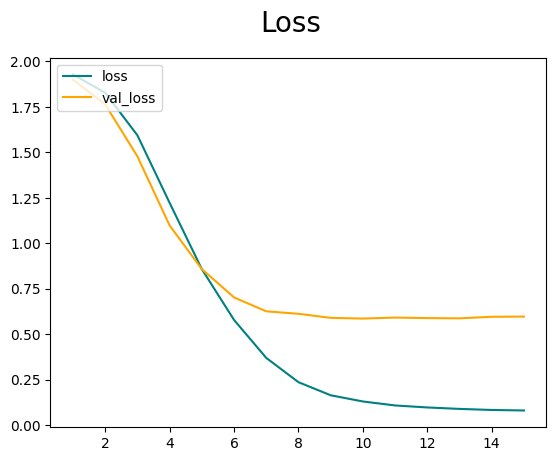

In [16]:
fig = plt.figure()
plt.plot(log_history['loss'], color='teal', label='loss')
plt.plot(log_history['eval_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Accuracy Curve
************

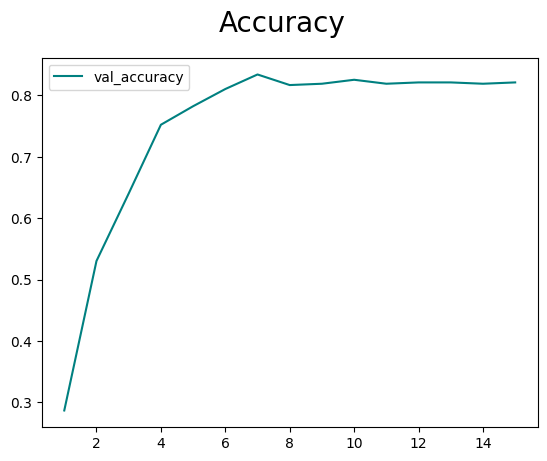

In [17]:
fig = plt.figure()
plt.plot(log_history['eval_accuracy'], color='teal', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Model Evaluation From Validation Data
************

In [18]:
metrics = trainer.evaluate(test_dataset)
trainer.log_metrics("test",metrics)
trainer.save_metrics("test",metrics)

c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\datasets\features\features.py:648: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  pa.PyExtensionType.__init__(self, self.storage_dtype)
***** Running Evaluation *****
  Num examples = 232
  Batch size = 16


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]

***** test metrics *****
  epoch                   =       15.0
  eval_accuracy           =     0.8103
  eval_loss               =     0.6872
  eval_runtime            = 0:00:07.28
  eval_samples_per_second =     31.865
  eval_steps_per_second   =       2.06


Test Model
************

In [19]:
y_test = trainer.predict(test_dataset)
y_test_acual = y_test.label_ids
y_test_pred = np.argmax(y_test.predictions, axis=1)
Y_pred_Df = pd.DataFrame(y_test_pred)
Y_test_Df = pd.DataFrame(y_test_acual)

c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\datasets\features\features.py:648: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  pa.PyExtensionType.__init__(self, self.storage_dtype)
***** Running Prediction *****
  Num examples = 232
  Batch size = 16


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Confusion Metrix
************

Text(0.5, 1.0, 'Confusion Matrix')

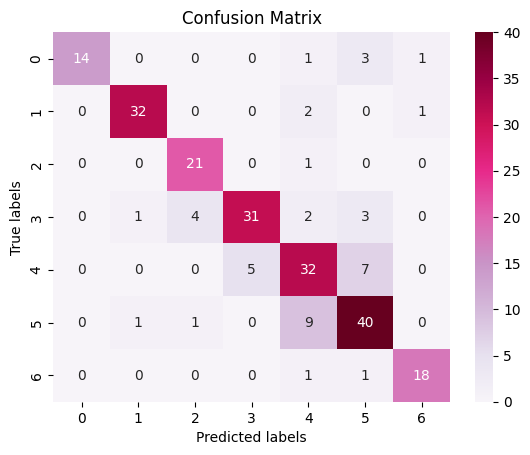

In [20]:
# Generate Confusion Metrix
cm = confusion_matrix(Y_pred_Df,Y_test_Df)
ax= plt.subplot()
sns.heatmap(cm, cmap='PuRd', annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# Set label,title name
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

Classification Report
************

In [21]:
print(classification_report(Y_test_Df,Y_pred_Df, target_names=(train_dataset.features["label"].names)))

              precision    recall  f1-score   support

      Basalt       0.74      1.00      0.85        14
        Coal       0.91      0.94      0.93        34
     Granite       0.95      0.81      0.88        26
   Limestone       0.76      0.86      0.81        36
      Marble       0.73      0.67      0.70        48
   Quartzite       0.78      0.74      0.76        54
   Sandstone       0.90      0.90      0.90        20

    accuracy                           0.81       232
   macro avg       0.82      0.85      0.83       232
weighted avg       0.81      0.81      0.81       232

